In [170]:
import os
import pickle
from itertools import combinations
import math
import pandas as pd
import re
import json
import binarymap as bmap
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
import jax
import jax.numpy as jnp
from jax.experimental import sparse
from jaxopt import ProximalGradient
import jaxopt
import numpy as onp
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
import sys
sys.path.append("..")
import multidms
from timeit import default_timer as timer
import importlib

In [512]:
# results

### Globals

In [163]:
exp_name = None #"clip_search"
substitution_column = 'aa_substitutions_reference'
experiment_column = 'homolog_exp'
scaled_func_score_column = 'log2e'

* Baseline 
    * (linear v non-linear)
* Clipped (-4, 2.5) Baseline
    * (linear v non-linear)
    * Scaled v Not scaling the counts
    
^ all the above repeated with library 3 (1)


+ update the baseline <- here


+ try removing the gamma param
+ try without stop codons

In [776]:
fit_params = {
    "fs_scaling_group_column" : "homolog_exp",
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "agg_variants" : True,
    "sample" : False, # 10000,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5), #None, # (-3.5, 2.5),
    "func_score_target" : 'log2e', #'func_score',
    "experiment_ref" : 'Delta-3-1', #'Omicron_BA.1-2-1', #'Delta-2-1',
    "experiment_2" : 'Omicron_BA.1-3-1',
    "shift_func_score_target_nonref" : False, #-1,# None, -1,
    "include_stop_variants" : True,
    "warmup_to_ref" : False,
    "maxiter" : 10000,
    "λ_lasso" : 1e-5,
    "λ_ridge" : 0,
    "model" : "non-linear"
}

In [777]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1", "Omicron_BA.2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)
    
    # WT Protein sequence
#     with open(f"../results/{homolog}/protein.fasta", "r") as seq_file:
#         header = seq_file.readline()
#         wt_seqs[homolog] = seq_file.readline().strip()

#     # Sites
#     sites[homolog] = (
#         pd.read_csv(f"../results/{homolog}/site_numbering_map.csv")
#         .rename({"sequential_site":f"{homolog}_site", "sequential_wt":f"{homolog}_wt"})
#         .set_index(["reference_site"])
#     )

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['homolog_exp'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)

In [778]:
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,homolog_exp
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-2
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-1
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-2
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-1
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-2
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-1
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-2


In [779]:
# ! rm results.pkl

In [780]:
# if not os.path.exists(f"{exp_name}.pkl"):
#     cols = list(fit_params.keys()) + [
#         "tuned_model_params", "all_subs", "variant_prediction_df"
#     ]
#     results = pd.DataFrame(columns = cols)
# else:
#     results = pickle.load(open(f"{exp_name}.pkl", "rb"))

In [781]:
if fit_params["experiment_2"]:
    func_score_data = func_score_data.query(
        f"{experiment_column}.isin(['{fit_params['experiment_ref']}', '{fit_params['experiment_2']}'])"
    )

In [782]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(homolog_exp=row.homolog_exp)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])

  0%|          | 0/2 [00:00<?, ?it/s]

In [783]:
if fit_params["sample"]:
    func_score_df = func_score_df.sample(fit_params["sample"])

In [784]:
func_score_df.aa_substitutions_reference.fillna("", inplace=True)
gapped_sub_vars = []
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    if "-" in row[substitution_column]:
        gapped_sub_vars.append(idx)
    for sub in row[substitution_column].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/162830 [00:00<?, ?it/s]

In [785]:
# TODO re-write and make function
# def normalize_by_freq()?
dfs = []
for (h, hdf) in func_score_df.groupby(fit_params["fs_scaling_group_column"]):
    n_post_counts = sum(hdf['post_count'])
    if 'Delta' in h:
        bottleneck = 1e5
        scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
    else:
        bottleneck = 1e5
        scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
    hdf['orig_post_count'] = hdf['post_count']
    hdf['post_count'] *= scaling_factor
    hdf['post_count_wt'] *= scaling_factor
    print(h, n_post_counts, round(scaling_factor, 2), round(sum(hdf['post_count']),2))

    # Recompute enrichment ratios with new counts
    hdf['pre_count_ps'] = hdf['pre_count'] + fit_params["pseudocount"]
    hdf['post_count_ps'] = hdf['post_count'] + fit_params["pseudocount"]
    hdf['pre_count_wt_ps'] = hdf['pre_count_wt'] + fit_params["pseudocount"]
    hdf['post_count_wt_ps'] = hdf['post_count_wt'] + fit_params["pseudocount"]

    total_pre_count = sum(hdf['pre_count_ps'])
    total_post_count = sum(hdf['post_count_ps'])

    hdf['pre_freq'] = hdf['pre_count_ps'] / total_pre_count
    hdf['post_freq'] = hdf['post_count_ps'] / total_post_count
    hdf['pre_freq_wt'] = hdf['pre_count_wt_ps'] / total_pre_count
    hdf['post_freq_wt'] = hdf['post_count_wt_ps'] / total_post_count

    hdf['wt_e'] = hdf['post_freq_wt'] / hdf['pre_freq_wt']
    hdf['var_e'] = hdf['post_freq'] / hdf['pre_freq']
    hdf['e'] = hdf['var_e'] / hdf['wt_e']
    #hdf.dropna(subset=['e'], inplace=True)
    hdf['log2e'] = hdf['e'].apply(lambda x: math.log(x, 2))
    dfs.append(hdf)
func_score_df = pd.concat(dfs)

Delta-3-1 3807421 0.03 100000.0
Omicron_BA.1-3-1 66389368 0.0 100000.0


In [786]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= fit_params["min_pre_counts"]]
#     print(f'Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {min_pre_counts} counts before selection, and were filtered out')

In [787]:
# func_score_df.head()["aa_substitutions_reference"]

In [788]:
len(func_score_df)

137402

In [789]:
# results["include_stop_variants"] = True
if not fit_params["include_stop_variants"]:
    stop_variants = [idx for idx, row in func_score_df.iterrows() if "*" in row[substitution_column]]
    func_score_df = func_score_df.drop(stop_variants)

In [790]:
len(func_score_df)

137402

In [791]:
if fit_params["agg_variants"]:
    func_score_df = func_score_df.groupby([substitution_column, experiment_column]).mean().reset_index()
func_score_df["pre_count"] = func_score_df["pre_count"].astype(int)
func_score_df["post_count"] = func_score_df["post_count"].astype(int)

In [792]:
# TODO, what's the order of operations?
if fit_params["shift_func_score_target_nonref"]:
    h2_idx = func_score_df.query(f"{experiment_column} == '{fit_params['experiment_2']}'").index
    func_score_df.loc[h2_idx, fit_params["func_score_target"]] += fit_params["shift_func_score_target_nonref"]

In [793]:
if fit_params['clip_target']:
    tar = fit_params["func_score_target"]
    func_score_df[tar] = func_score_df[tar].clip(*fit_params["clip_target"])

In [794]:
importlib.reload(multidms.utils)

<module 'multidms.utils' from '/home/jgallowa/Projects/multidms/notebooks/../multidms/utils.py'>

In [795]:
cols = list(fit_params.keys()) + [
    "tuned_model_params", "all_subs", "variant_prediction_df", "site_map"
]
# results = pd.DataFrame(columns = cols)

In [796]:
# multidms = importlib.reload(multidms)
(X, y), df, all_subs, site_map = multidms.utils.create_homolog_modeling_data(
                            func_score_df, 
                            experiment_column,
                            fit_params["experiment_ref"],
                            substitution_column,
                            fit_params["func_score_target"]
                        )

sig_upper = df[fit_params["func_score_target"]].quantile(0.95)
sig_lower = df[fit_params["func_score_target"]].quantile(0.05)
sig_range = sig_upper - sig_lower

Found 8 site(s) lacking data in at least one homolog.
2723 of the 86572 variants were removed because they had mutations at the above sites, leaving 83849 variants.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 58556/58556 [01:57<00:00, 496.78it/s]


There were 0 cache hits in total for homolog Omicron_BA.1-3-1.


In [769]:
# fit_params["maxiter"] = 10000
# fit_params["model"] = "linear"
# fit_params["λ_lasso"] = 1e-5
# fit_params["lasso"] 

In [797]:
# Initialize all params
params = multidms.utils.initialize_model_params(
    func_score_df[experiment_column].unique(), 
    n_beta_shift_params=X[fit_params["experiment_ref"]].shape[1],
    include_alpha=True if fit_params["model"] == "non-linear" else False,
    init_sig_range=sig_range,
    init_sig_min=sig_lower
)

In [798]:
params

{'β': DeviceArray([-0.57334713, -0.20234694, -0.40719932, ..., -0.68163857,
               0.71620482,  0.99943656], dtype=float64),
 'S_Delta-3-1': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'C_Delta-3-1': DeviceArray([0.], dtype=float64),
 'γ_Delta-3-1': DeviceArray([0.], dtype=float64),
 'S_Omicron_BA.1-3-1': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'C_Omicron_BA.1-3-1': DeviceArray([0.], dtype=float64),
 'γ_Omicron_BA.1-3-1': DeviceArray([0.], dtype=float64),
 'α': {'ge_scale': DeviceArray([4.20404354], dtype=float64),
  'ge_bias': DeviceArray([-3.36967609], dtype=float64)},
 'C_ref': DeviceArray([5.], dtype=float64)}

In [799]:
importlib.reload(multidms.model)
if fit_params["model"] == "non-linear":
    cost_func = multidms.model.cost_smooth
    prox_func = multidms.model.prox
    pred_func = multidms.model.f 
else:
    cost_func = multidms.model.cost_smooth_linear
    prox_func = multidms.model.prox_linear
    pred_func = multidms.model.f_linear 

In [800]:
print(f"\nPre-Optimization")
print(f"----------------")
print(f"cost = {cost_func(params, (X, y), λ_ridge=fit_params['λ_ridge']):.2e}")

tol = 1e-6
maxiter = fit_params['maxiter']
start = timer()

solver = ProximalGradient(cost_func, prox_func, tol=tol, maxiter=maxiter)

# Next, jointly fit data on both homologs
print('Fitting model to both homologs')
params, state = solver.run(
    params, 
    hyperparams_prox = dict(
        lasso_params = {
            f"S_{fit_params['experiment_2']}" : fit_params['λ_lasso']
        },
        lock_params = {
            f"S_{fit_params['experiment_ref']}" : jnp.zeros(len(params['β'])),
            f"C_{fit_params['experiment_ref']}" : jnp.zeros(shape=(1,)),
            f"C_{fit_params['experiment_2']}" : jnp.zeros(shape=(1,)),
            f"γ_{fit_params['experiment_ref']}" : jnp.zeros(shape=(1,))
        }
    ),
    data=(X, y),
    λ_ridge=fit_params['λ_ridge']
)
end = timer()

print(f"\nPost-Optimization")
print(f"-----------------")
print(f"Full model optimization: {state.iter_num} iterations")
print(f"error = {state.error:.2e}")
print(f"cost = {cost_func(params, (X, y)):.2e}")
print(f"Wall time for fit: {end - start}")
print(f"\nDONE :)")
print(f"-------------------")


Pre-Optimization
----------------
cost = 2.85e+00
Fitting model to both homologs

Post-Optimization
-----------------
Full model optimization: 10000 iterations
error = 8.96e-04
cost = 4.72e-01
Wall time for fit: 108.76376203261316

DONE :)
-------------------


In [802]:
for param in ["β", f"S_{fit_params['experiment_2']}"]:
    print(f"\nFit {param} distribution\n===============")
    if param not in params:
        continue
    arr = onp.array(params[param])
    mean = onp.mean(arr)
    median = onp.median(arr)

    # measures of dispersion
    min = onp.amin(arr)
    max = onp.amax(arr)
    range = onp.ptp(arr)
    variance = onp.var(arr)
    sd = onp.std(arr)

    print("Descriptive analysis")
    print("Measures of Central Tendency")
    print(f"Mean = {mean:.2e}")
    print(f"Median = {median:.2e}")
    print("Measures of Dispersion")
    print(f"Minimum = {min:.2e}")
    print(f"Maximum = {max:.2e}")
    print(f"Range = {range:.2e}")
    print(f"Variance = {variance:.2e}")
    print(f"Standard Deviation = {sd:.2e}")

for param, value in params.items():
    if param in ["β", f"S_{fit_params['experiment_ref']}", f"S_{fit_params['experiment_2']}"]: continue
    print(f"{param}: {value}")
    print()

df["predicted_latent_phenotype"] = onp.nan
df[f"predicted_{fit_params['func_score_target']}"] = onp.nan

print(f"\nRunning Predictions")
print(f"-------------------")
for homolog, hdf in df.groupby(experiment_column):
    
    h_params = {
        "β":params["β"], 
        "C_ref":params["C_ref"],
        "S":params[f"S_{homolog}"], 
        "C":params[f"C_{homolog}"],
        "γ":params[f"γ_{homolog}"]
    }
    if fit_params["model"] == "non-linear": h_params["α"] = params["α"]
    
    z_h = multidms.model.ϕ(h_params, X[homolog])
    df.loc[hdf.index, "predicted_latent_phenotype"] = z_h

    y_h_pred = pred_func(h_params, X[homolog])
    df.loc[hdf.index, f"predicted_{fit_params['func_score_target']}"] = y_h_pred
    
print(f"\nDONE :)")
print(f"-------------------")

row = fit_params.copy()

# merge parms and respective subs in df
row["tuned_model_params"] = params.copy()
row["all_subs"] = all_subs.copy()


row["variant_prediction_df"] = df.drop("index", axis=1)
row["site_map"] = site_map.copy()

# results = pd.Series(row)
results.loc[len(results)] = pd.Series(row)


Fit β distribution
Descriptive analysis
Measures of Central Tendency
Mean = -1.22e+00
Median = -7.12e-01
Measures of Dispersion
Minimum = -1.03e+01
Maximum = 6.25e+00
Range = 1.66e+01
Variance = 3.99e+00
Standard Deviation = 2.00e+00

Fit S_Omicron_BA.1-3-1 distribution
Descriptive analysis
Measures of Central Tendency
Mean = -2.83e-02
Median = 0.00e+00
Measures of Dispersion
Minimum = -4.91e+00
Maximum = 4.70e+00
Range = 9.61e+00
Variance = 4.23e-01
Standard Deviation = 6.50e-01
C_Delta-3-1: [0.]

C_Omicron_BA.1-3-1: [0.]

C_ref: [2.53087998]

α: {'ge_bias': DeviceArray([-4.35113503], dtype=float64), 'ge_scale': DeviceArray([4.64867493], dtype=float64)}

γ_Delta-3-1: [0.]

γ_Omicron_BA.1-3-1: [1.84551828]


Running Predictions
-------------------

DONE :)
-------------------


In [803]:
results.loc[3:, ["agg_variants", "clip_target", "func_score_target", "model", "experiment_ref", "experiment_2", "include_stop_variants"]]

,agg_variants,clip_target,func_score_target,model,experiment_ref,experiment_2,include_stop_variants
3,True,None,func_score,linear,Delta-2-1,Omicron_BA.1-2-1,True
4,True,None,func_score,non-linear,Delta-2-1,Omicron_BA.1-2-1,True
5,True,"(-3.5, 2.5)",func_score,linear,Delta-2-1,Omicron_BA.1-2-1,True
6,True,"(-3.5, 2.5)",func_score,non-linear,Delta-2-1,Omicron_BA.1-2-1,True
7,True,"(-3.5, 2.5)",log2e,linear,Delta-2-1,Omicron_BA.1-2-1,True
8,True,"(-3.5, 2.5)",log2e,non-linear,Delta-2-1,Omicron_BA.1-2-1,True
9,True,None,func_score,linear,Delta-3-1,Omicron_BA.1-3-1,True
10,True,None,func_score,non-linear,Delta-3-1,Omicron_BA.1-3-1,True
11,True,"(-3.5, 2.5)",func_score,linear,Delta-3-1,Omicron_BA.1-3-1,True
12,True,"(-3.5, 2.5)",func_score,non-linear,Delta-3-1,Omicron_BA.1-3-1,True


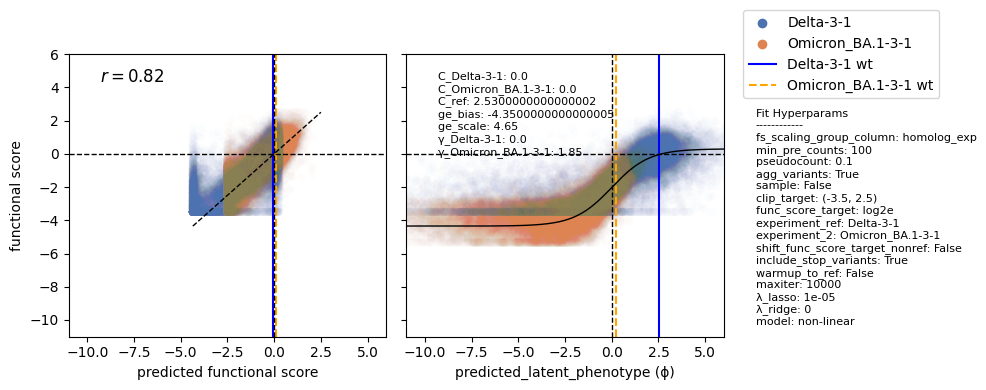

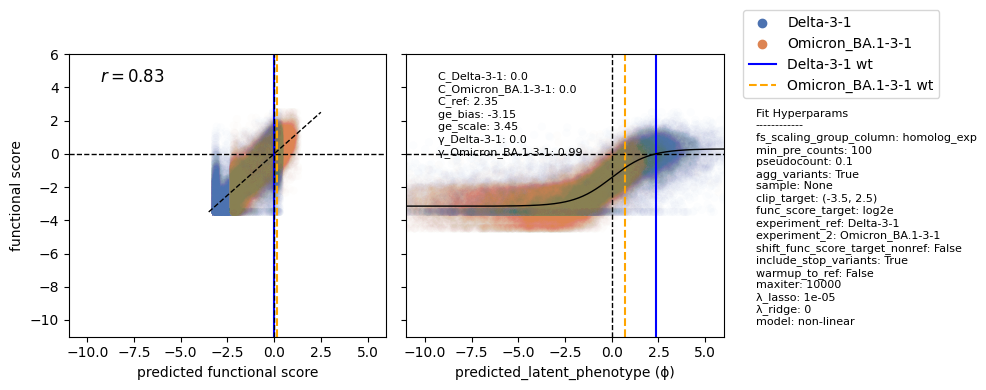

In [805]:
exps = [23, 14]
res = results.loc[exps, :]
multidms.plot.plot_pred_scatter(
    res, 
    annotation_vars=list(fit_params.keys()), 
    hue=True, 
    printrow=False,
    annotate_params=True,
)
# multidms.plot.plot_param_hist(
#     res,
#     printrow=False
# )
# multidms.plot.plot_param_heatmap(
#     res, 
#     printrow=False
# )
# multidms.plot.plot_shift_by_site(
#     res, 
#     printrow=False
# )

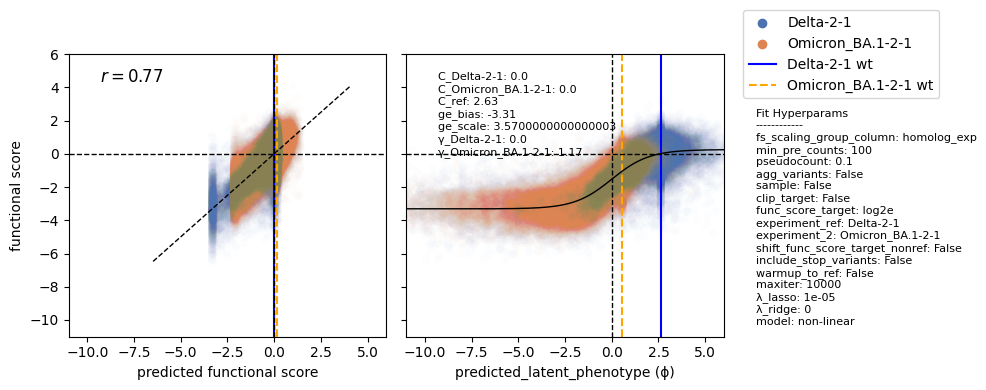

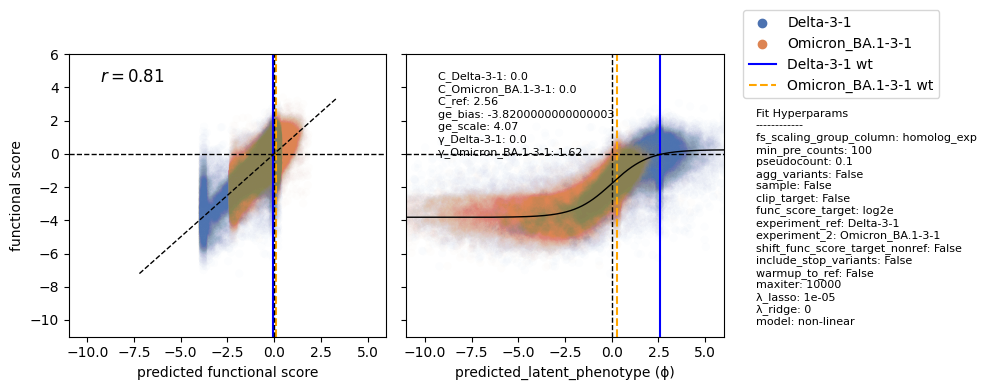

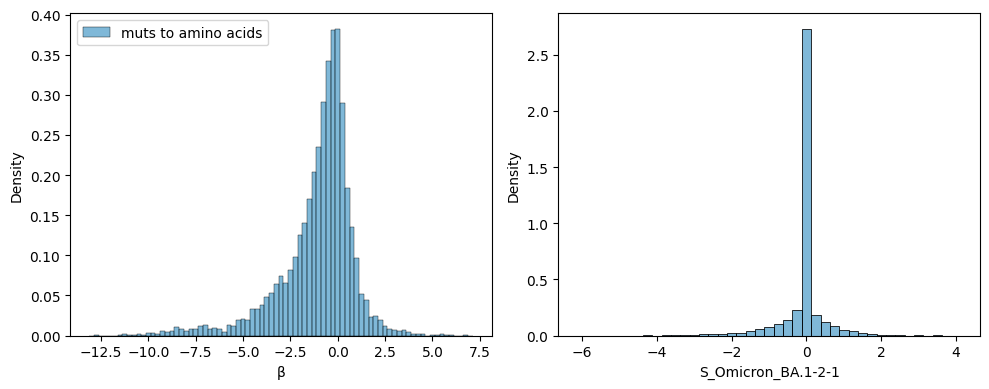

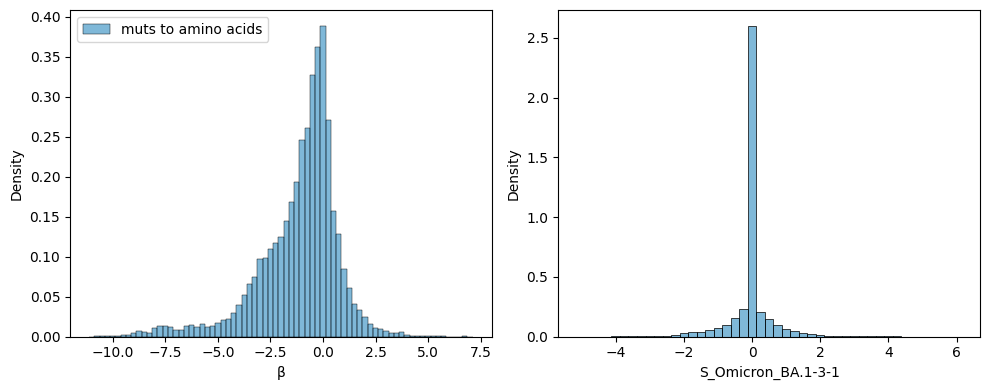

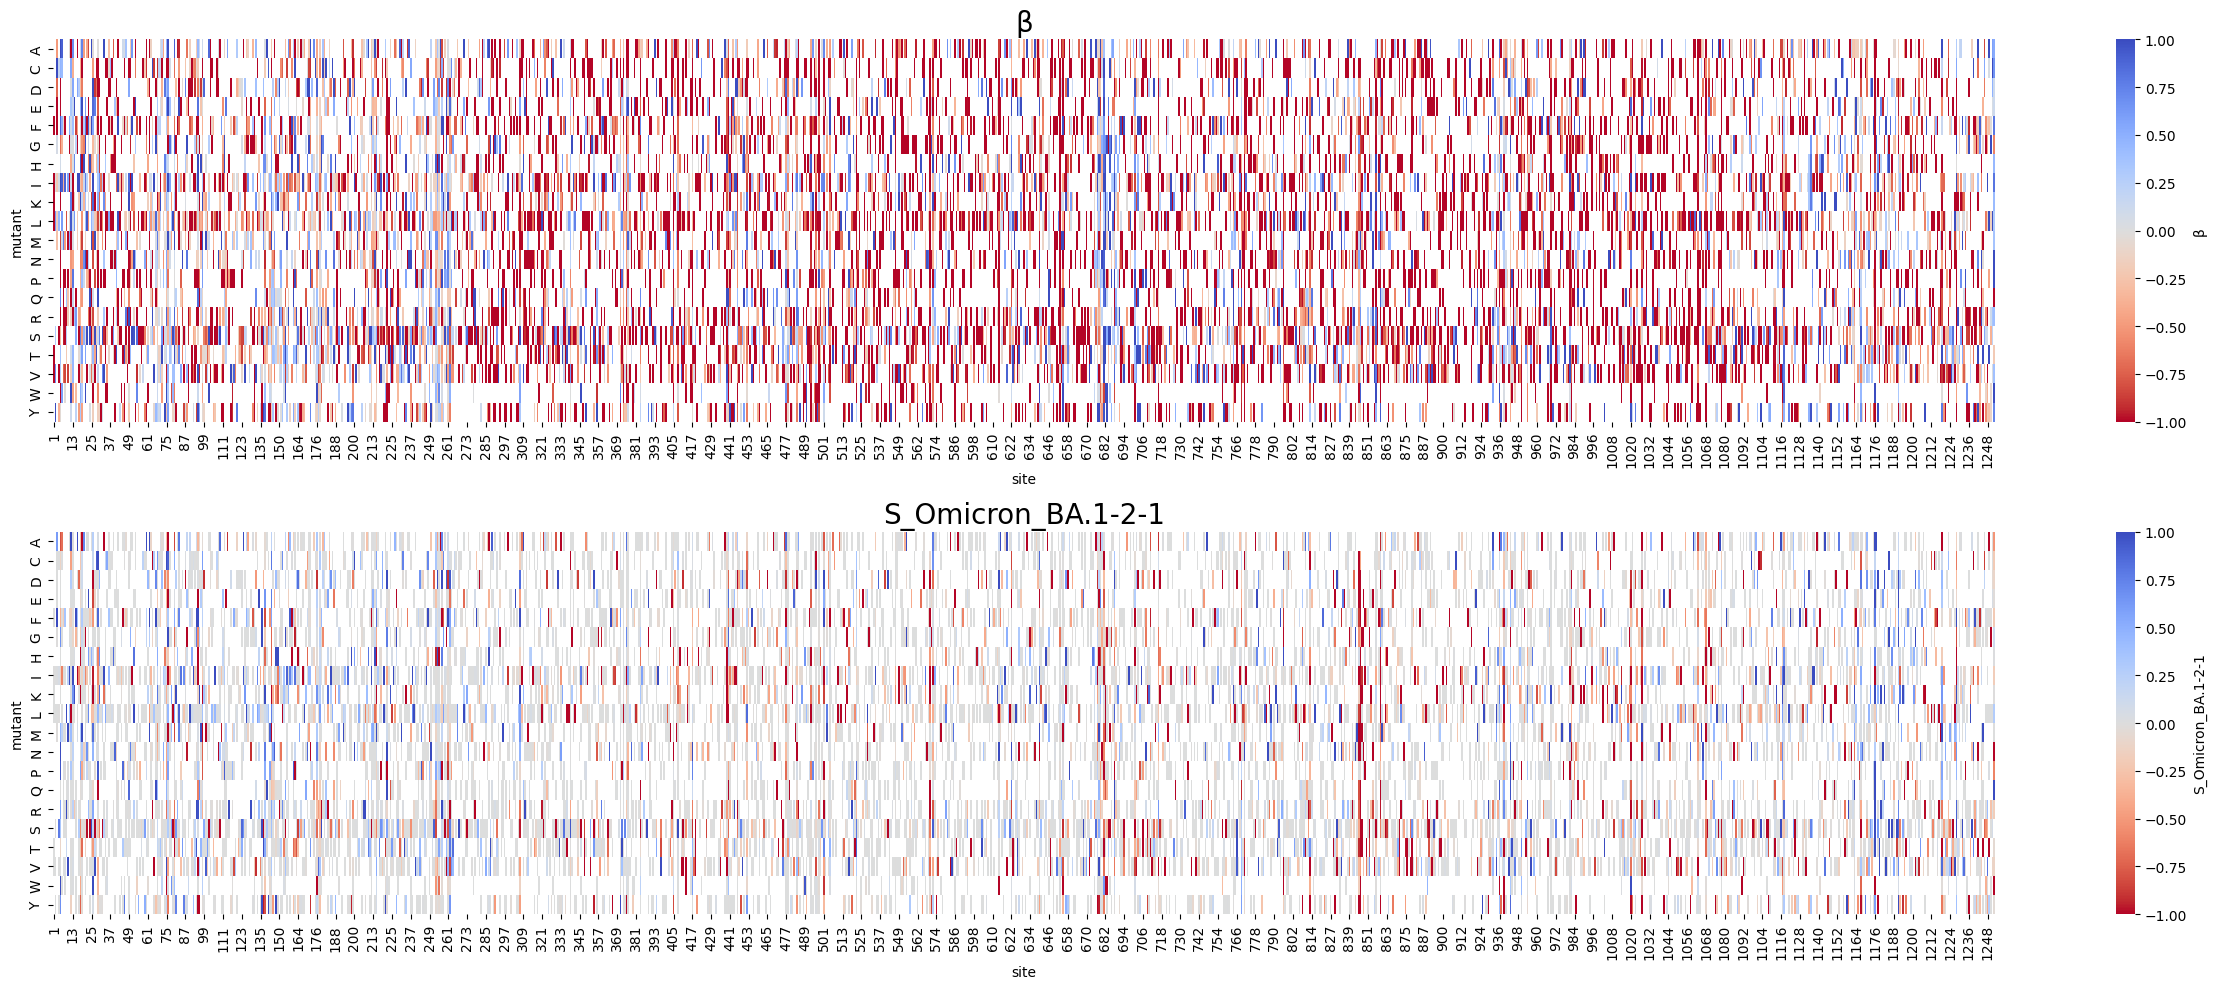

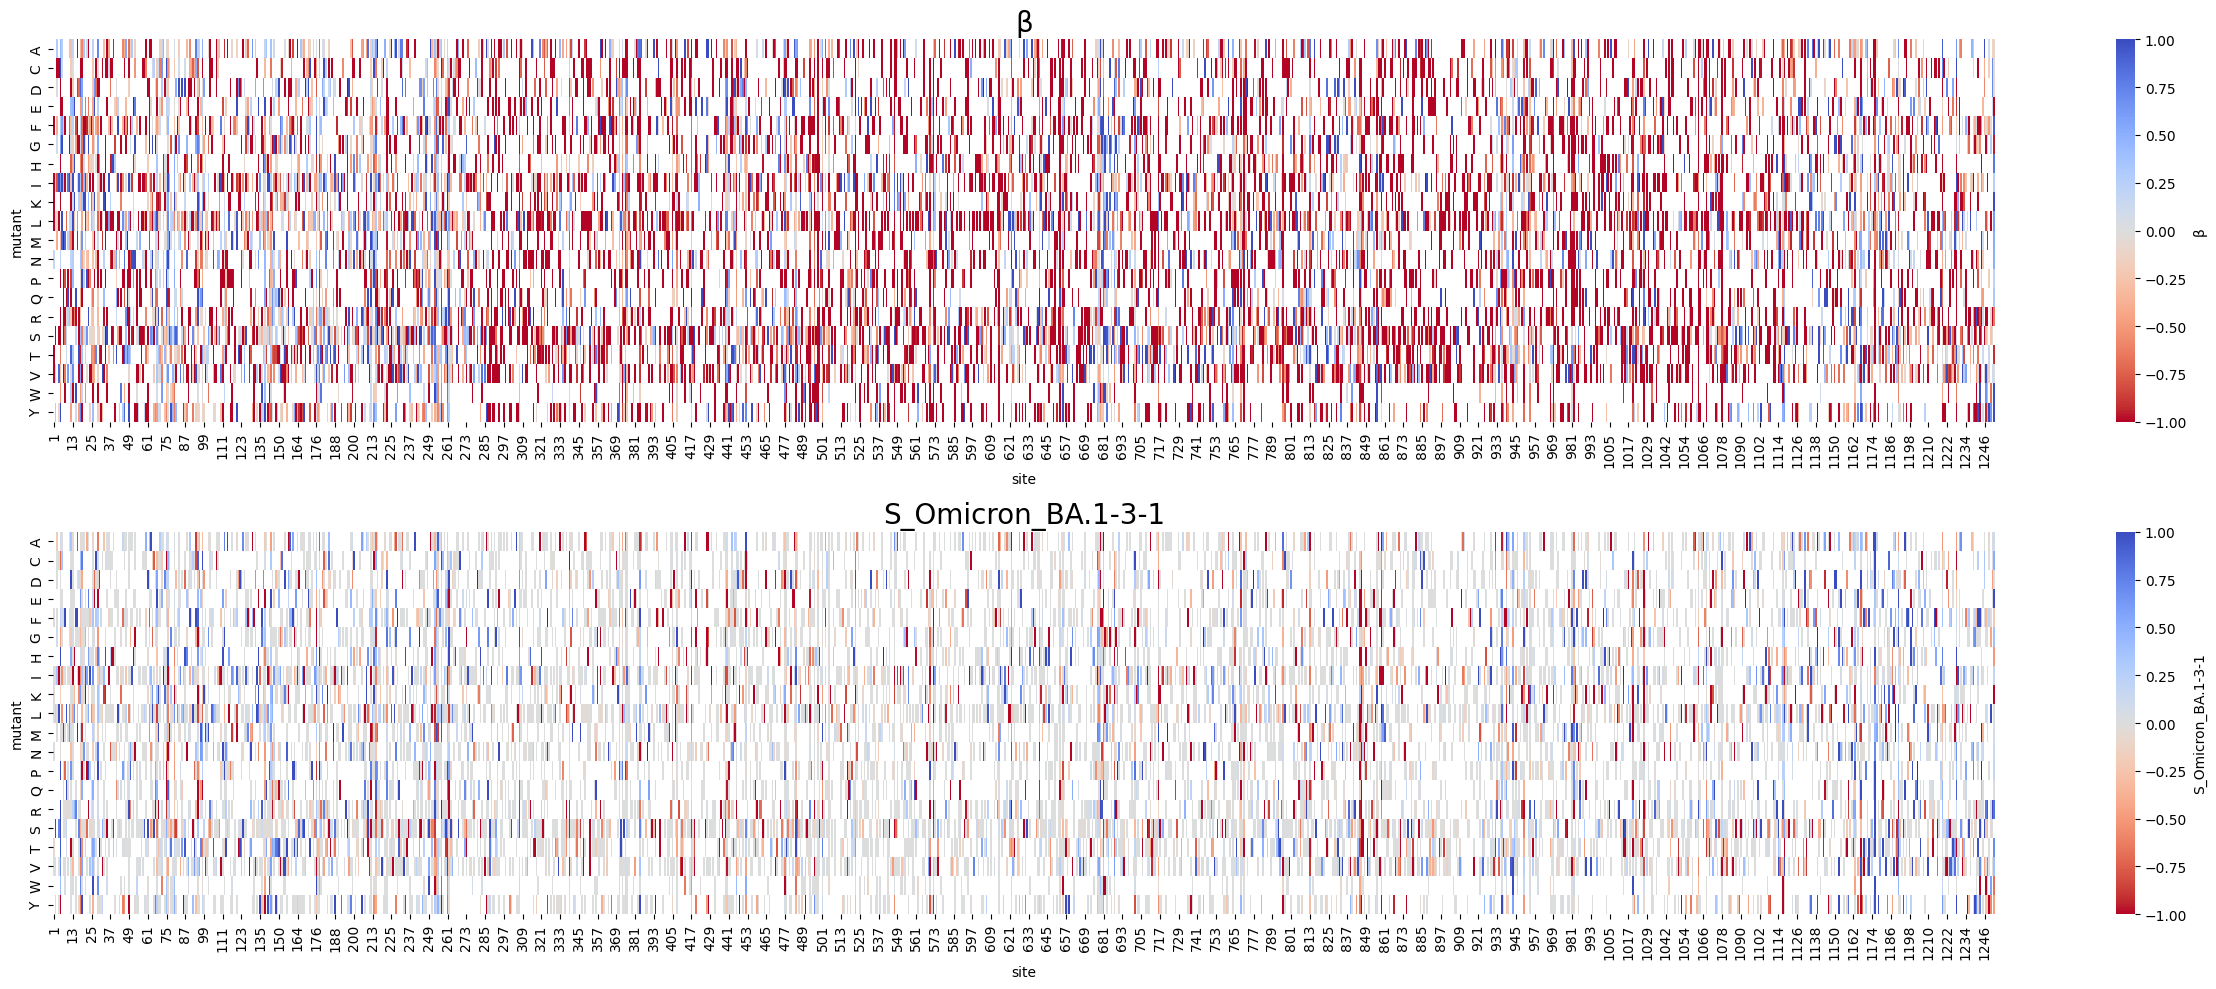

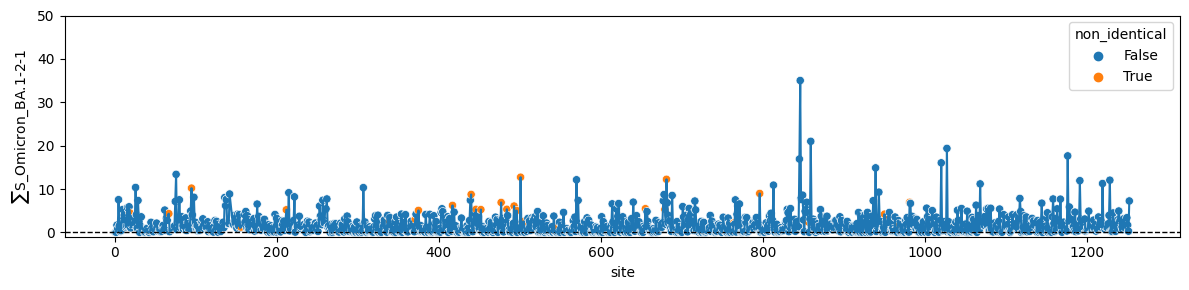

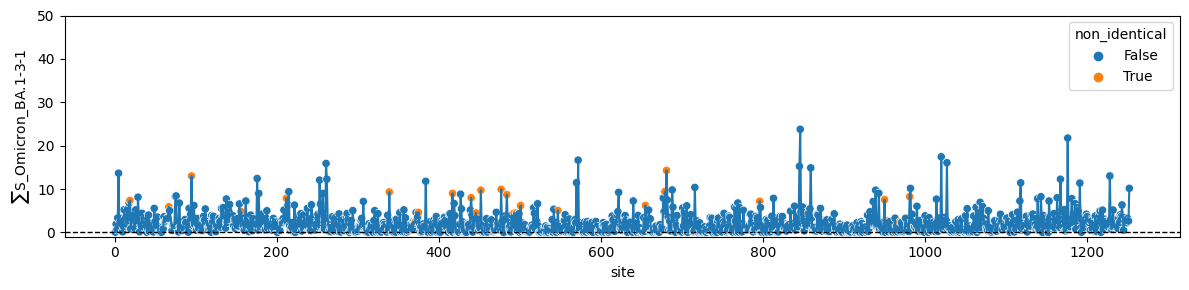

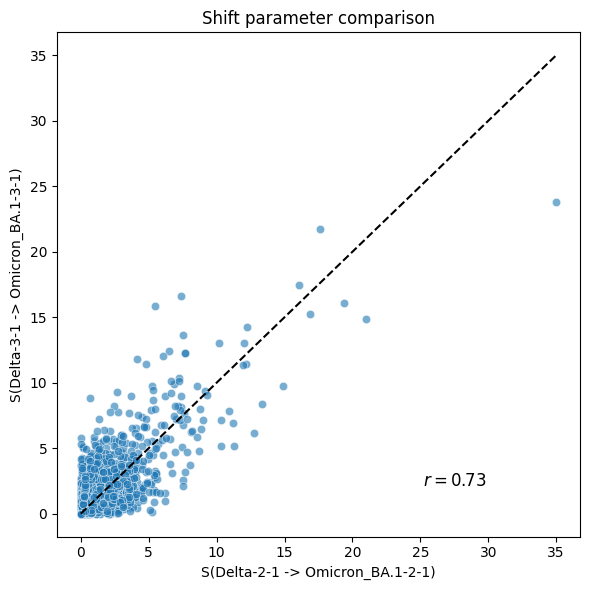

In [747]:
exps = [20, 21]
res = results.loc[exps, :]
multidms.plot.plot_pred_scatter(
    res, 
    annotation_vars=list(fit_params.keys()), 
    hue=True, 
    printrow=False,
    annotate_params=True,
)
multidms.plot.plot_param_hist(
    res,
    printrow=False
)
multidms.plot.plot_param_heatmap(
    res, 
    printrow=False
)
multidms.plot.plot_shift_by_site(
    res, 
    printrow=False
)
multidms.plot.plot_fit_param_site_comp_scatter(
    res, 
    idx_1=exps[0], idx_2=exps[1]
)

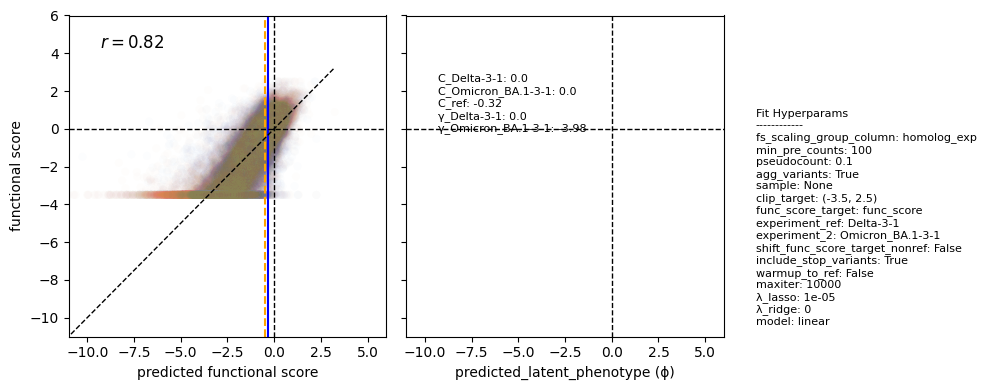

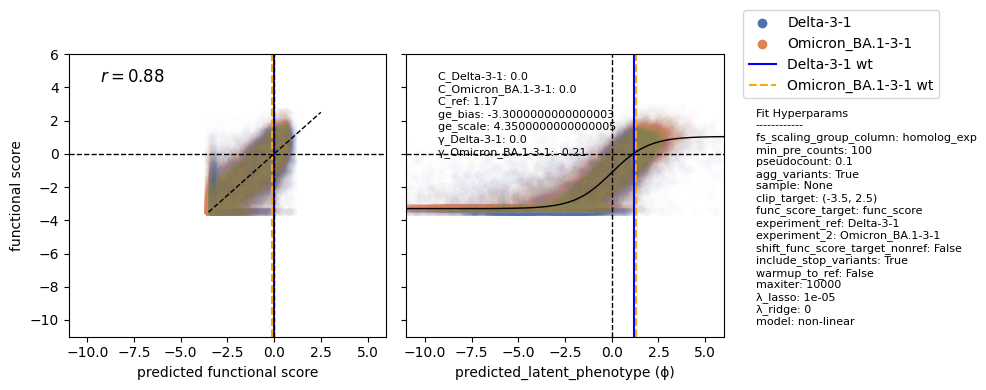

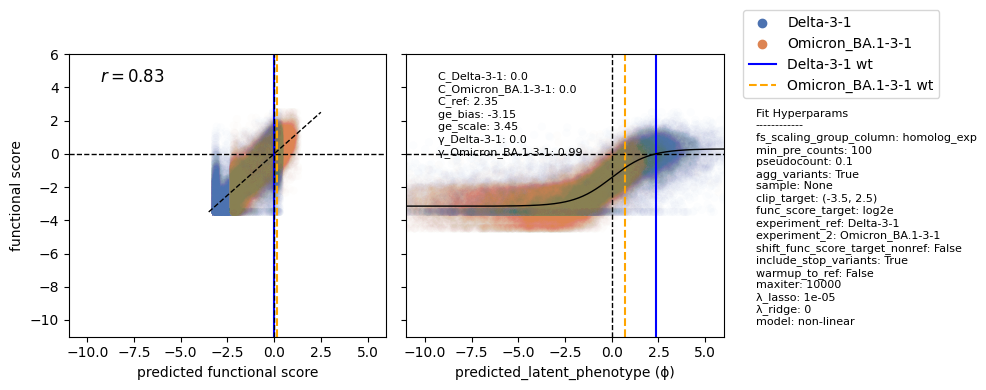

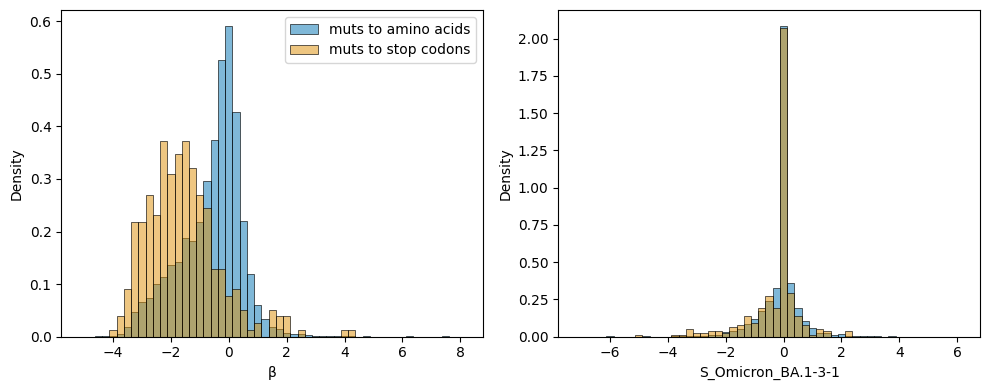

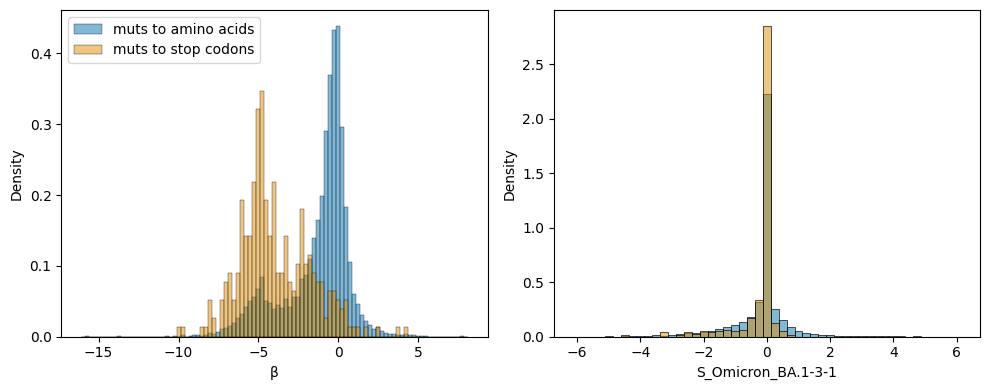

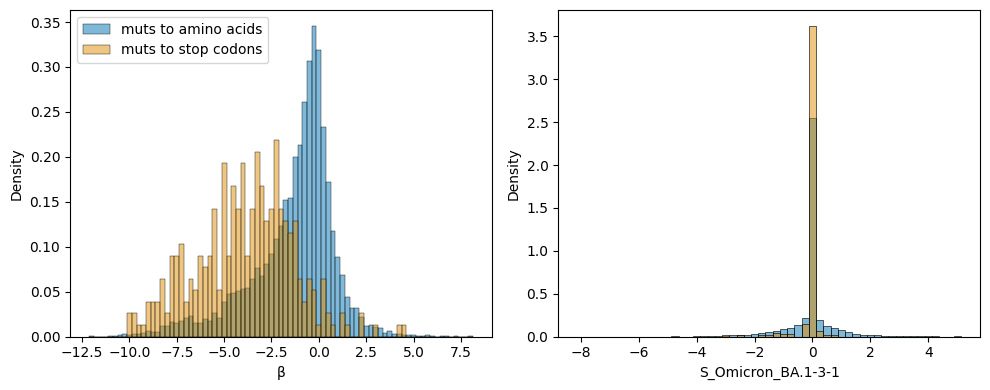

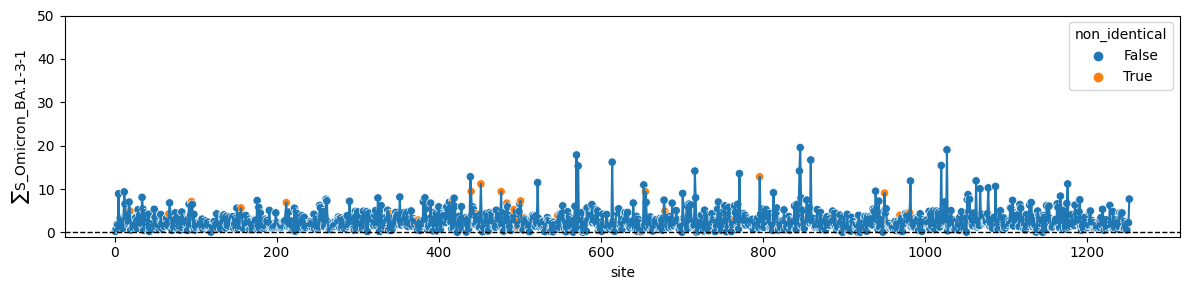

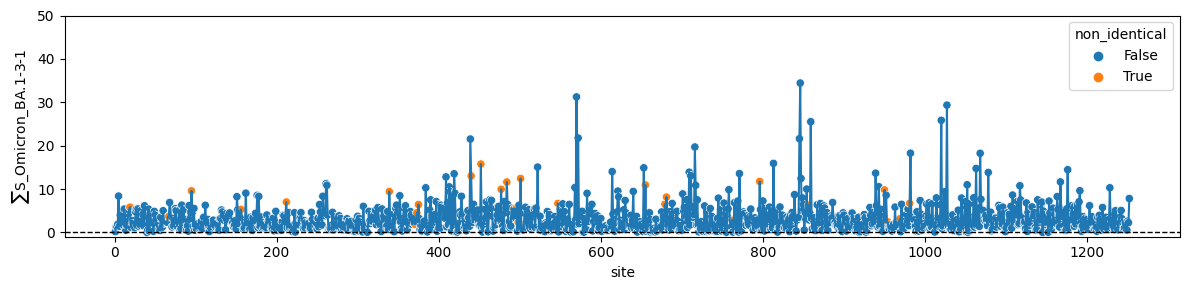

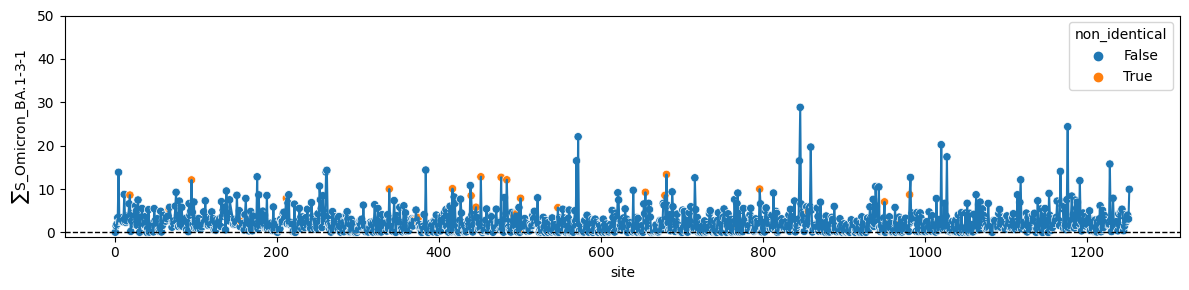

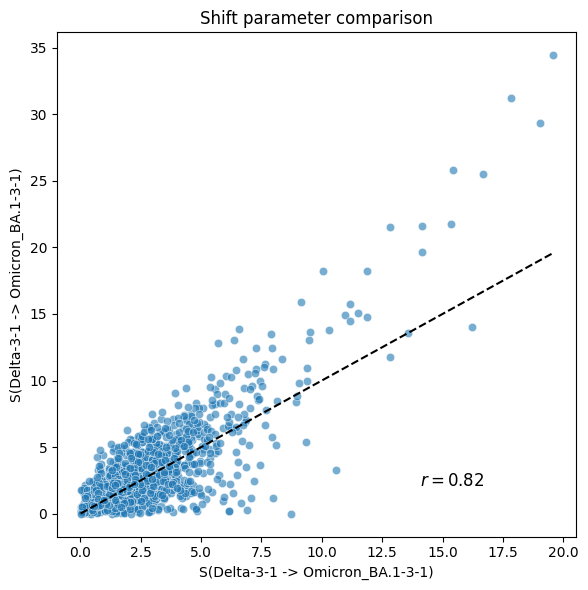

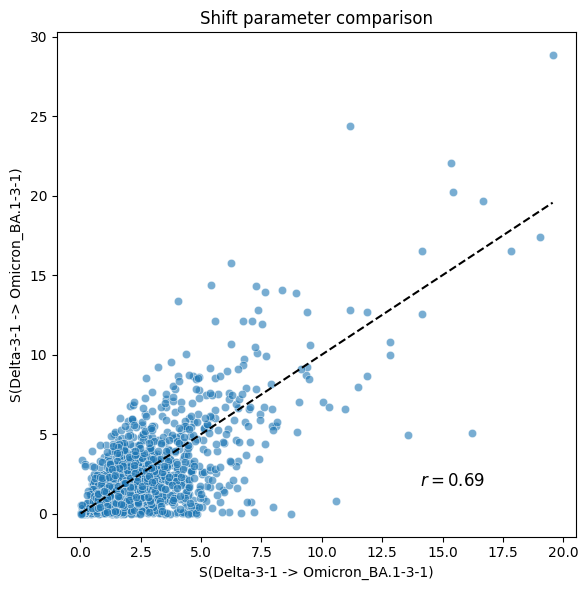

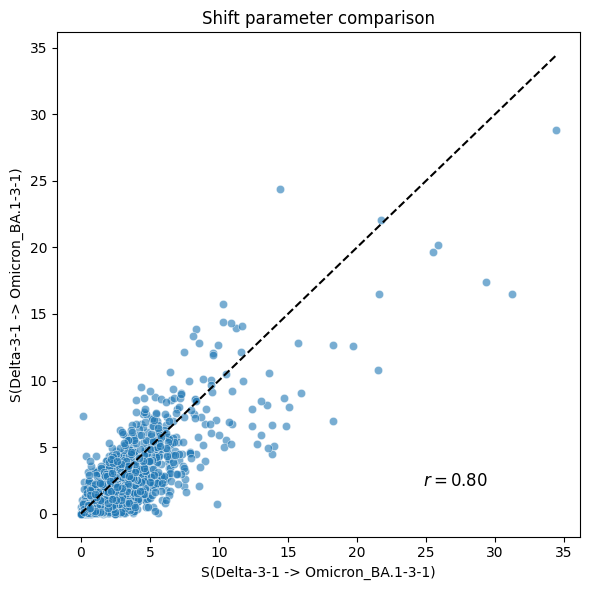

In [717]:
importlib.reload(multidms.plot)
# exps = [3,9,4,10]
# exps = [5,11,6,12]
# exps = [7,13,8,14]
# exps = [15,16]
# exps = [17,18]

# 11 - best linear, no rescaling, yes clipping
# 12 - best non linear without scaling
# 14 - best non linear with scaling

exps = [11, 12, 14]




res = results.loc[exps, :]
multidms.plot.plot_pred_scatter(
    res, 
    annotation_vars=list(fit_params.keys()), 
    hue=True, 
    printrow=False,
    annotate_params=True,
)
multidms.plot.plot_param_hist(
    res,
    printrow=False
)

# multidms.plot.plot_param_heatmap(
#     res, 
#     printrow=False
# )


multidms.plot.plot_shift_by_site(
    res, 
    printrow=False
)
# multidms.plot.plot_fit_param_comp_scatter(
#     res, 
#     idx_1=exps[0], idx_2=exps[1]
# )
# multidms.plot.plot_fit_param_comp_scatter(
#     res, 
#     idx_1=exps[2], idx_2=exps[3]
# )

multidms.plot.plot_fit_param_site_comp_scatter(
    res, 
    idx_1=exps[0], idx_2=exps[1]
)
multidms.plot.plot_fit_param_site_comp_scatter(
    res, 
    idx_1=exps[0], idx_2=exps[2]
)
multidms.plot.plot_fit_param_site_comp_scatter(
    res, 
    idx_1=exps[1], idx_2=exps[2]
)
# multidms.plot.plot_fit_param_site_comp_scatter(
#     res, 
#     idx_1=exps[2], idx_2=exps[3]
# )